### Libs

In [ ]:
!cd "/content/drive/MyDrive/MRI Arman/STYLEGAN_FAST"

In [1]:
from torchvision.datasets import CelebA
import os
import torch.nn as nn
import glob
import os
import torch
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import os
import torch
import math
# main libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
from torch.nn import functional as F
from torch import nn
from torch import optim
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset
import math
import torchvision.transforms.functional as TF
import cv2
from keras.utils import image_dataset_from_directory
from torchvision import datasets, transforms
from torch.utils.data import random_split
from torch.nn.parameter import Parameter

from torch.nn import init
from torchvision.utils import make_grid
from collections import OrderedDict

import torch
from torch.utils.data import Dataset

from skimage import transform
import skimage.io as io
import numpy as np
from torchvision.utils import save_image

In [ ]:
from torchvision.models import vgg16

### Helper Functions

In [112]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 128, 128)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [ ]:
def ploter(image, image_hat):
    """
    (H, W)
    """
    plt.figure()
    plt.subplot(1,2,1)
    #plt.imshow(image_hat, cmap='gray', vmin=-1, vmax=1)
    plt.imshow(image_hat)
    plt.tight_layout()
    plt.title("Reconstruct")

    plt.subplot(1,2,2)
    #plt.imshow(image, cmap='gray', vmin=-1, vmax=1)
    plt.imshow(image)
    plt.tight_layout()
    plt.title("Original")

    plt.show()

### Generator

In [98]:
# original implementation: https://github.com/odegeasslbc/FastGAN-pytorch/blob/main/models.py
#
# modified by Axel Sauer for "Projected GANs Converge Faster"
#
import torch.nn as nn
from pg_modules.blocks import (InitLayer, UpBlockBig, UpBlockBigCond, UpBlockSmall, UpBlockSmallCond, SEBlock, conv2d)


def normalize_second_moment(x, dim=1, eps=1e-8):
    return x * (x.square().mean(dim=dim, keepdim=True) + eps).rsqrt()


class DummyMapping(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, z, c=None, **kwargs):
        return z.unsqueeze(1)  # to fit the StyleGAN API


class FastganSynthesis(nn.Module):
    def __init__(self, ngf=128, z_dim=256, nc=3, img_resolution=256, lite=False):
        super().__init__()
        self.img_resolution = img_resolution
        self.z_dim = z_dim

        # channel multiplier
        nfc_multi = {2: 16, 4:16, 8:8, 16:4, 32:2, 64:2, 128:1, 256:0.5,
                     512:0.25, 1024:0.125}
        nfc = {}
        for k, v in nfc_multi.items():
            nfc[k] = int(v*ngf)

        # layers
        self.init = InitLayer(z_dim, channel=nfc[2], sz=4)

        UpBlock = UpBlockSmall if lite else UpBlockBig

        self.feat_8   = UpBlock(nfc[4], nfc[8])
        self.feat_16  = UpBlock(nfc[8], nfc[16])
        self.feat_32  = UpBlock(nfc[16], nfc[32])
        self.feat_64  = UpBlock(nfc[32], nfc[64])
        self.feat_128 = UpBlock(nfc[64], nfc[128])
        self.feat_256 = UpBlock(nfc[128], nfc[256])

        self.se_64  = SEBlock(nfc[4], nfc[64])
        self.se_128 = SEBlock(nfc[8], nfc[128])
        self.se_256 = SEBlock(nfc[16], nfc[256])

        self.to_big = conv2d(nfc[img_resolution], nc, 3, 1, 1, bias=True)

        if img_resolution > 256:
            self.feat_512 = UpBlock(nfc[256], nfc[512])
            self.se_512 = SEBlock(nfc[32], nfc[512])
        if img_resolution > 512:
            self.feat_1024 = UpBlock(nfc[512], nfc[1024])

    def forward(self, input, c=None, **kwargs):
        # map noise to hypersphere as in "Progressive Growing of GANS"
        input = normalize_second_moment(input[:, 0])

        feat_4 = self.init(input)
        feat_8 = self.feat_8(feat_4)
        feat_16 = self.feat_16(feat_8)
        feat_32 = self.feat_32(feat_16)
        feat_64 = self.se_64(feat_4, self.feat_64(feat_32))

        if self.img_resolution >= 64:
            feat_last = feat_64

        if self.img_resolution >= 128:
            feat_last = self.se_128(feat_8,  self.feat_128(feat_last))

        if self.img_resolution >= 256:
            feat_last = self.se_256(feat_16, self.feat_256(feat_last))

        if self.img_resolution >= 512:
            feat_last = self.se_512(feat_32, self.feat_512(feat_last))

        if self.img_resolution >= 1024:
            feat_last = self.feat_1024(feat_last)

        return self.to_big(feat_last)


class FastganSynthesisCond(nn.Module):
    def __init__(self, ngf=64, z_dim=256, nc=3, img_resolution=256, num_classes=1000, lite=False):
        super().__init__()

        self.z_dim = z_dim
        nfc_multi = {2: 16, 4:16, 8:8, 16:4, 32:2, 64:2, 128:1, 256:0.5,
                     512:0.25, 1024:0.125, 2048:0.125}
        nfc = {}
        for k, v in nfc_multi.items():
            nfc[k] = int(v*ngf)

        self.img_resolution = img_resolution

        self.init = InitLayer(z_dim, channel=nfc[2], sz=4)

        UpBlock = UpBlockSmallCond if lite else UpBlockBigCond

        self.feat_8   = UpBlock(nfc[4], nfc[8], z_dim)
        self.feat_16  = UpBlock(nfc[8], nfc[16], z_dim)
        self.feat_32  = UpBlock(nfc[16], nfc[32], z_dim)
        self.feat_64  = UpBlock(nfc[32], nfc[64], z_dim)
        self.feat_128 = UpBlock(nfc[64], nfc[128], z_dim)
        self.feat_256 = UpBlock(nfc[128], nfc[256], z_dim)

        self.se_64 = SEBlock(nfc[4], nfc[64])
        self.se_128 = SEBlock(nfc[8], nfc[128])
        self.se_256 = SEBlock(nfc[16], nfc[256])

        self.to_big = conv2d(nfc[img_resolution], nc, 3, 1, 1, bias=True)

        if img_resolution > 256:
            self.feat_512 = UpBlock(nfc[256], nfc[512])
            self.se_512 = SEBlock(nfc[32], nfc[512])
        if img_resolution > 512:
            self.feat_1024 = UpBlock(nfc[512], nfc[1024])

        self.embed = nn.Embedding(num_classes, z_dim)

    def forward(self, input, c, update_emas=False):
        c = self.embed(c.argmax(1))

        # map noise to hypersphere as in "Progressive Growing of GANS"
        input = normalize_second_moment(input[:, 0])

        feat_4 = self.init(input)
        feat_8 = self.feat_8(feat_4, c)
        feat_16 = self.feat_16(feat_8, c)
        feat_32 = self.feat_32(feat_16, c)
        feat_64 = self.se_64(feat_4, self.feat_64(feat_32, c))
        feat_128 = self.se_128(feat_8,  self.feat_128(feat_64, c))

        if self.img_resolution >= 128:
            feat_last = feat_128

        if self.img_resolution >= 256:
            feat_last = self.se_256(feat_16, self.feat_256(feat_last, c))

        if self.img_resolution >= 512:
            feat_last = self.se_512(feat_32, self.feat_512(feat_last, c))

        if self.img_resolution >= 1024:
            feat_last = self.feat_1024(feat_last, c)

        return self.to_big(feat_last)


class Generator(nn.Module):
    def __init__(
        self,
        z_dim=100,
        c_dim=0,
        w_dim=0,
        img_resolution=128,
        img_channels=3,
        ngf=16,
        cond=0,
        mapping_kwargs={},
        synthesis_kwargs={},
        **kwargs,
    ):
        super().__init__()
        self.z_dim = z_dim
        self.c_dim = c_dim
        self.w_dim = w_dim
        self.img_resolution = img_resolution
        self.img_channels = img_channels

        # Mapping and Synthesis Networks
        self.mapping = DummyMapping()  # to fit the StyleGAN API
        Synthesis = FastganSynthesisCond if cond else FastganSynthesis
        self.synthesis = Synthesis(ngf=ngf, z_dim=z_dim, nc=img_channels, img_resolution=img_resolution, **synthesis_kwargs)

    def forward(self, z, c, **kwargs):
        w = self.mapping(z, c)
        img = self.synthesis(w, c)
        return img

In [99]:
# TEST
G = Generator()
z = torch.FloatTensor(np.random.normal(0, 1, (10, 100)))
img = G(z, 0)

### Discriminator

In [ ]:
# NOTE:
# AGE DARI AZ WGANGP ESTEFADE MIKONI SIGMOID RO DELETE KON!!!

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()


        self.conv_layers_vgg = vgg16().features[:9+1]
    

        self.conv_layers_fabrik = nn.Sequential(
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )


        self.adverse_layer = nn.Sequential(
            nn.Linear(128 * 8 * 8, 1),
            nn.Sigmoid()
            )

    def forward(self, image):
        out = self.conv_layers_vgg(image)
        out = self.conv_layers_fabrik(out)

        out = out.view(out.shape[0], -1)
        validity = self.adverse_layer(out)
        return validity

In [ ]:
# TEST
x = torch.ones(10, 3, 128, 128)
discriminator = Discriminator()
print(discriminator(x).shape)
count_parameters(discriminator)

In [ ]:
def convert_relu_to_softplus(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, nn.LeakyReLU(negative_slope=0.2))
        else:
            convert_relu_to_softplus(child)

#convert_relu_to_softplus(discriminator)

### NEW Disc

In [ ]:
!pip install wget
import wget
filename = wget.download("https://storage.googleapis.com/vit_models/imagenet21k/ViT-B_16.npz")
discriminator.ViT.load_from(np.load(filename))

In [2]:
from models.modeling import CONFIGS, VisionTransformer

In [3]:
class Discriminator(nn.Module):
    def __init__(self, config = CONFIGS['ViT-B_16'], vit_image_size = 128):
        super(Discriminator, self).__init__()

        self.ViT = VisionTransformer(config, vit_image_size, num_classes=1, zero_head=True)
        filename = wget.download("https://storage.googleapis.com/vit_models/imagenet21k/ViT-B_16.npz")
        self.ViT.load_from(np.load(filename))

    def forward(self, x):
        return self.ViT(x)[0]

In [152]:
model = VisionTransformer(CONFIGS['ViT-B_16'], 128, num_classes=1, zero_head=True)
N, C, H, W = 10, 3, 128, 128
x = torch.ones(N, C, H, W)

x = model.transformer.embeddings(x)

model.transformer.encoder.layer[0:2]

ModuleList(
  (0): Block(
    (attention_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (ffn_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (ffn): Mlp(
      (fc1): Linear(in_features=768, out_features=3072, bias=True)
      (fc2): Linear(in_features=3072, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (attn): Attention(
      (query): Linear(in_features=768, out_features=768, bias=True)
      (key): Linear(in_features=768, out_features=768, bias=True)
      (value): Linear(in_features=768, out_features=768, bias=True)
      (out): Linear(in_features=768, out_features=768, bias=True)
      (attn_dropout): Dropout(p=0.0, inplace=False)
      (proj_dropout): Dropout(p=0.0, inplace=False)
      (softmax): Softmax(dim=-1)
    )
  )
  (1): Block(
    (attention_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (ffn_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (ffn): Mlp(
      (fc1)

In [153]:
model

VisionTransformer(
  (transformer): Transformer(
    (embeddings): Embeddings(
      (patch_embeddings): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): Encoder(
      (layer): ModuleList(
        (0): Block(
          (attention_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (ffn_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (ffn): Mlp(
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (attn): Attention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (out): Linear(in_features=768, out_features=768, bias=True)
     

In [150]:
model.transformer.encoder.layer

ModuleList(
  (0): Block(
    (attention_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (ffn_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (ffn): Mlp(
      (fc1): Linear(in_features=768, out_features=3072, bias=True)
      (fc2): Linear(in_features=3072, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (attn): Attention(
      (query): Linear(in_features=768, out_features=768, bias=True)
      (key): Linear(in_features=768, out_features=768, bias=True)
      (value): Linear(in_features=768, out_features=768, bias=True)
      (out): Linear(in_features=768, out_features=768, bias=True)
      (attn_dropout): Dropout(p=0.0, inplace=False)
      (proj_dropout): Dropout(p=0.0, inplace=False)
      (softmax): Softmax(dim=-1)
    )
  )
  (1): Block(
    (attention_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (ffn_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (ffn): Mlp(
      (fc1)

In [142]:
model.transformer.embeddings

Embeddings(
  (patch_embeddings): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (dropout): Dropout(p=0.1, inplace=False)
)

In [132]:
model = VisionTransformer(CONFIGS['ViT-B_16'], 128, num_classes=1, zero_head=True)


N, T = 100, 768
x = torch.ones(N, T)
model.transformer.encoder.layer[0](x)

RuntimeError: number of dims don't match in permute

In [ ]:
discriminator = Discriminator()

In [ ]:
!pip install wget

In [ ]:
import wget
filename = wget.download("https://storage.googleapis.com/vit_models/imagenet21k/ViT-B_16.npz")
discriminator.ViT.load_from(np.load(filename))

In [ ]:
def freeze_model(model, layers=6):
    for i in range(layers):
        for p in model.transformer.encoder.layer[i].parameters():
            p.requires_grad = False

In [ ]:
freeze_model(discriminator.ViT)

### Losses

In [ ]:
def discriminator_layers_loss(discriminator, vgg, real_images, lamda = 0):
    # CONV2D # 0, 2, 5, 7
    # RELU   # 1, 3, 6, 8
    # SALEHI # 9, 16, 23, 30
    # max #1, 4, 6, 9


    criterion = nn.MSELoss()
    similarity_loss = torch.nn.CosineSimilarity()

    y_pred_1, y_pred_3, y_pred_6, y_pred_8 = discriminator.conv_layers_vgg[:1+1](real_images),\
                                             discriminator.conv_layers_vgg[:4+1](real_images),\
                                             discriminator.conv_layers_vgg[:6+1](real_images),\
                                             discriminator.conv_layers_vgg[:9+1](real_images)

    y_1, y_3, y_6, y_8 = vgg.features[:1+1](real_images),\
                         vgg.features[:4+1](real_images),\
                         vgg.features[:6+1](real_images),\
                         vgg.features[:9+1](real_images)


    abs_loss_1 = criterion(y_pred_1, y_1)
    loss_1 = torch.mean(1 - similarity_loss(y_pred_1.view(y_pred_1.shape[0], -1), y_1.view(y_1.shape[0], -1)))

    abs_loss_3 = criterion(y_pred_3, y_3)
    loss_3 = torch.mean(1 - similarity_loss(y_pred_3.view(y_pred_3.shape[0], -1), y_3.view(y_3.shape[0], -1)))

    abs_loss_6 = criterion(y_pred_6, y_6)
    loss_6 = torch.mean(1 - similarity_loss(y_pred_6.view(y_pred_6.shape[0], -1), y_6.view(y_6.shape[0], -1)))

    abs_loss_8 = criterion(y_pred_8, y_8)
    loss_8 = torch.mean(1 - similarity_loss(y_pred_8.view(y_pred_8.shape[0], -1), y_8.view(y_8.shape[0], -1)))


    total_loss = loss_1 + loss_3 + loss_6 + loss_8 + lamda * (
                    abs_loss_1 + abs_loss_3 + abs_loss_6 + abs_loss_8)

    return total_loss

In [ ]:
# mitoni hamin kar ro baraye generator ham beri k layer haye mokhtalef mese ham bashe
def generator_layers_loss(vgg, real_images, gen_imgs, lamda = 0):
    # CONV2D # 0, 2, 5, 7
    # RELU   # 1, 3, 6, 8

    criterion = nn.MSELoss()
    similarity_loss = torch.nn.CosineSimilarity()

    y_pred_1, y_pred_3, y_pred_6, y_pred_8 = vgg.features[:1+1](gen_imgs),\
                                             vgg.features[:3+1](gen_imgs),\
                                             vgg.features[:6+1](gen_imgs),\
                                             vgg.features[:8+1](gen_imgs)

    y_1, y_3, y_6, y_8 = vgg.features[:1+1](real_images),\
                         vgg.features[:3+1](real_images),\
                         vgg.features[:6+1](real_images),\
                         vgg.features[:8+1](real_images)


    abs_loss_1 = criterion(y_pred_1, y_1)
    loss_1 = torch.mean(1 - similarity_loss(y_pred_1.view(y_pred_1.shape[0], -1), y_1.view(y_1.shape[0], -1)))

    abs_loss_3 = criterion(y_pred_3, y_3)
    loss_3 = torch.mean(1 - similarity_loss(y_pred_3.view(y_pred_3.shape[0], -1), y_3.view(y_3.shape[0], -1)))

    abs_loss_6 = criterion(y_pred_6, y_6)
    loss_6 = torch.mean(1 - similarity_loss(y_pred_6.view(y_pred_6.shape[0], -1), y_6.view(y_6.shape[0], -1)))

    abs_loss_8 = criterion(y_pred_8, y_8)
    loss_8 = torch.mean(1 - similarity_loss(y_pred_8.view(y_pred_8.shape[0], -1), y_8.view(y_8.shape[0], -1)))


    total_loss = loss_1 + loss_3 + loss_6 + loss_8 + lamda * (
                    abs_loss_1 + abs_loss_3 + abs_loss_6 + abs_loss_8)

    return total_loss

### Hyperparameters

In [ ]:
#root_save = "./best_models"
#root_ds = "./../../../dataset/kaggle1/no"
device = 'cuda'

root_save = "/content/drive/MyDrive/MRI Arman/best_models"
root_ds = "/content/drive/MyDrive/MRI Arman/dataset/kaggle1/no"

batch_size = 10
img_size = 128
latent_dim = 100
channels = 3
num_epochs = 5000
sample_interval = 10

num_data = 91

n_critic = 5
lambda_gp =10

### Dataset

In [71]:
class CustomDataset(Dataset):
    def __init__(self, folder:str, img_size = 128, BGR2GRAY = True, transforms = None):
        super(CustomDataset, self).__init__()

        self.folder = folder
        self.img_list  =  os.listdir(folder)
        self.transforms = transforms
        self.img_size = img_size
        self.BGR2GRAY = BGR2GRAY

    def __getitem__(self, item):
        img_dir = os.path.join(self.folder, self.img_list[item])
        img = cv2.imread(img_dir)
        if self.BGR2GRAY:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (self.img_size,self.img_size))

        if self.transforms:
            img = self.transforms(img)

        return img


    def __len__(self):
        return len(img_list)

In [88]:
folder = "F:/GitHub/anomaly-detection/dataset/kaggle1/no/normal"

trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,], std=[0.229,])])

dataset = CustomDataset(folder, transforms=trans)
train_loader = DataLoader(dataset, batch_size= 10)

In [89]:
for i, x in enumerate(train_loader,1):
    x=x
    break

In [91]:
x[0].min()

tensor(-2.1179)

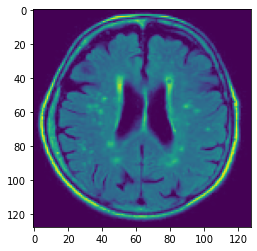

In [87]:
plt.imshow(x[6][0])

In [33]:
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [36]:
trans(x).shape

TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>

In [29]:
x.shape

torch.Size([10, 128, 128, 3])

In [3]:
folder = "F:/GitHub/anomaly-detection/dataset/kaggle1/no/normal"
import os
import cv2

item=0

img_list  =  os.listdir(folder)
img_dir = os.path.join(folder,img_list[item])
img = cv2.imread(img_dir)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (128,128))

In [ ]:
def load_images(folder):

    imgs = []
    target = 1
    labels = []
    for i in os.listdir(folder):
        img_dir = os.path.join(folder,i)
        try:
            img = cv2.imread(img_dir)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (128,128))
            imgs.append(img)
            labels.append(target)
        except:
            continue

    imgs = np.array(imgs)
    labels = np.array(labels)

    return imgs, labels

In [ ]:
folder = "F:/GitHub/anomaly-detection/dataset/kaggle1/no/normal"
img_list = os.listdir(folder)
img_dir = os.path.join(folder,img_list[item])
img = np.float64(io.imread(img_dir))
#img = transform.resize(img, 128)
#img = img.reshape((1,)+128)
img = (img-np.mean(img))/np.max(np.abs(img))
img = torch.FloatTensor(img)

In [ ]:
import skimage.io as io
import numpy as np

item = 0
#folder = "./../dataset/kaggle1/no/normal"
folder = "F:/GitHub/anomaly-detection/dataset/kaggle1/no/normal"
img_list = os.listdir(folder)
img_dir = os.path.join(folder,img_list[item])
img = np.float64(io.imread(img_dir))

In [18]:
class CustomDataset(Dataset):
    def __init__(self, root:str, transform=None):
        super(CustomDataset, self).__init__()

        self.root = root
        self.img_list = os.listdir(root)
        self.transform = transform

    def __getitem__(self, item):
        img_dir = os.path.join(self.root ,self.img_list[item])
        img = np.float64(io.imread(img_dir))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (128,128))

        return img

    def __len__(self):
        return len(self.img_list)

In [19]:
folder = "F:/GitHub/anomaly-detection/dataset/kaggle1/no/normal"

dataset = CustomDataset(folder)
train_loader = DataLoader(dataset, batch_size= 10)

In [20]:
for i, x in enumerate(train_loader,1):
    x=x
    break

error: OpenCV(4.5.5) d:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.simd_helpers.hpp:94: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<3,4,-1>,struct cv::impl::A0x7123906f::Set<1,-1,-1>,struct cv::impl::A0x7123906f::Set<0,2,5>,2>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Unsupported depth of input image:
>     'VDepth::contains(depth)'
> where
>     'depth' is 6 (CV_64F)


In [51]:
x[0].min()

tensor(-2.1179)

In [ ]:
indx = list(range(num_data))

train_sampler = SubsetRandomSampler(indx[:81])
test_sampler = SubsetRandomSampler(indx[81:])

In [ ]:
dataset = Anomaly_Dataset(root_ds)
train_loader = DataLoader(dataset, batch_size= batch_size, sampler=train_sampler)
test_loader=DataLoader(dataset, batch_size= len(test_sampler), sampler=test_sampler)

### Loss

In [ ]:
#os.environ['TORCH_HOME'] = './../pretrain_models'
#vgg = vgg16(torchvision.models.VGG16_Weights).to(device)

In [ ]:
#generator = Generator(init_size=8, latent_dim=100, channels=3).cuda()
generator = Generator().to(device)
#discriminator = Discriminator().to(device)

In [ ]:
adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters())
optimizer_D = optim.Adam(discriminator.parameters())

In [ ]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)

In [ ]:
#generator = generator.apply(weights_init_normal)
#discriminator = discriminator.apply(weights_init_normal)

### WGAN

In [ ]:
from torch.autograd import Variable
Tensor = torch.cuda.FloatTensor # Cuda
import torch.autograd as autograd

def compute_gradient_penalty(discriminator, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = Tensor(np.random.random((real_samples.size(0), 1, 1, 1)))
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = discriminator(interpolates)
    fake = Variable(Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

### torch.load

In [ ]:
"""
info = torch.load(root_last_model)
generator.load_state_dict(info["state_dict_G"])
discriminator.load_state_dict(info["state_dict_D"])
optimizer_G.load_state_dict(info["optimizer_G"])
optimizer_D.load_state_dict(info["optimizer_D"])
init_epoch = info['epoch']
"""

init_epoch = 0
device = 'cuda'
discriminator = discriminator.cuda()

In [ ]:

for epoch in range(init_epoch, num_epochs+1):
    total_G_loss = 0.0
    total_D_loss = 0.0

    # Load Train Data ##############################################
    for i, (real_images, _) in enumerate(train_loader):

        # Preprocessing ##############################################
        real_images = real_images.unsqueeze(1).cuda()
        real_images = real_images.repeat(1,3,1,1)


        # Train Discriminator ########################################
        z = torch.FloatTensor(np.random.normal(0, 1, (real_images.shape[0], latent_dim))).cuda()
        gen_imgs = generator(z, 0)


        optimizer_D.zero_grad()
        real_validity = discriminator(real_images)
        fake_validity = discriminator(gen_imgs.detach())
        gradient_penalty = compute_gradient_penalty(discriminator, real_images, gen_imgs.detach())
        d_loss_adv = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty


        #d_loss_layers = discriminator_layers_loss(discriminator, vgg, real_images, lamda = 0.01)


        d_loss = d_loss_adv #+ d_loss_layers
        d_loss.backward()
        optimizer_D.step()
        total_D_loss += d_loss.cpu().detach().numpy()



        # Train Generator ########################################
        if i % n_critic == 0:
            z = torch.FloatTensor(np.random.normal(0, 1, (real_images.shape[0], latent_dim))).cuda()
            gen_imgs = generator(z, 0)

            optimizer_G.zero_grad()
            fake_validity = discriminator(gen_imgs)
            g_loss_adv = -torch.mean(fake_validity)


            g_loss = g_loss_adv
            g_loss.backward(retain_graph=True)
            optimizer_G.step()
            total_G_loss += g_loss.cpu().detach().numpy()


    # Load Test Data ##############################################
    if epoch % sample_interval ==0:
        for _, (real_images, _) in enumerate(test_loader):
            # Preprocessing ##############################################
            real_images = real_images.unsqueeze(1).cuda()
            real_images = real_images.repeat(1,3,1,1)

            z = torch.FloatTensor(np.random.normal(0, 1, (real_images.shape[0], latent_dim))).cuda()
            gen_imgs = generator(z, 0)

            # Visualization ##############################################
            #show_tensor_images(gen_imgs)
            #show_tensor_images(real_images)
            num = math.floor(np.random.uniform(0, len(test_loader)))
            ploter(real_images.detach().cpu()[num][0], gen_imgs.detach().cpu()[num][0])


        # Losses ##############################################
        print("[Epoch {}/{}] \t[D loss: {:.3f}] \t[G loss: {:.3f}]".format(epoch, num_epochs, total_D_loss, total_G_loss))
        # SAVE ##############################################
        """
        torch.save({"epoch": epoch,
        "state_dict_G": generator.state_dict(),
        "state_dict_D": discriminator.state_dict(),
        "optimizer_G": optimizer_G.state_dict(),
        "optimizer_D": optimizer_D.state_dict()
        }, root_save + f"/epoch_{epoch}.pt")
        """

### Vanila GAN

In [ ]:
init_epoch = 0
device = 'cuda'
discriminator = discriminator.cuda()

In [ ]:
for epoch in range(init_epoch, num_epochs+1):
    total_G_loss = 0.0
    total_D_loss = 0.0

    # Load Train Data ##############################################
    for i, (real_images, _) in enumerate(train_loader):

        # Preprocessing ##############################################
        valid = torch.FloatTensor(real_images.shape[0], 1).fill_(1.0).to(device)
        fake = torch.FloatTensor(real_images.shape[0], 1).fill_(0.0).to(device)
        
        real_images = real_images.unsqueeze(1).to(device)
        real_images = real_images.repeat(1,3,1,1)


        # Train Generator ########################################
        optimizer_G.zero_grad()
        z = torch.FloatTensor(np.random.normal(0, 1, (real_images.shape[0], latent_dim))).to(device)
        gen_imgs = generator(z, 0)
        g_loss_adv = adversarial_loss(discriminator(gen_imgs), valid)
        
        g_loss = g_loss_adv
        g_loss.backward()
        optimizer_G.step()
        total_G_loss += g_loss.cpu().detach().numpy()



        # Train Discriminator ########################################
        for _ in range(1):
          optimizer_D.zero_grad()
          discriminator_opinion_real = discriminator(real_images)
          discriminator_opinion_fake = discriminator(gen_imgs.detach())
          real_loss = adversarial_loss(discriminator_opinion_real, valid)
          fake_loss = adversarial_loss(discriminator_opinion_fake, fake)

          d_loss_adv = (real_loss + fake_loss) / 2

          #d_loss_layers = discriminator_layers_loss(discriminator, vgg, real_images, lamda = 0.0)


          d_loss = d_loss_adv #+ d_loss_layers
          d_loss.backward()
          optimizer_D.step()
        total_D_loss += d_loss.cpu().detach().numpy()


    # Load Test Data ##############################################
    if epoch % sample_interval ==0:
        for _, (real_images, _) in enumerate(test_loader):
            # Preprocessing ##############################################
            real_images = real_images.unsqueeze(1).to(device)
            real_images = real_images.repeat(1,3,1,1)

            z = torch.FloatTensor(np.random.normal(0, 1, (real_images.shape[0], latent_dim))).to(device)
            gen_imgs = generator(z, 0)

            # Visualization ##############################################
            #show_tensor_images(gen_imgs)
            #show_tensor_images(real_images)
            num = math.floor(np.random.uniform(0, len(test_loader)))
            ploter(real_images.detach().cpu()[num][0], gen_imgs.detach().cpu()[num][0])


        # Losses ##############################################
        print("[Epoch {}/{}] \t[D loss: {:.3f}] \t[G loss: {:.3f}]".format(epoch, num_epochs, total_D_loss, total_G_loss))
        # SAVE ##############################################

        """
        torch.save({"epoch": epoch,
        "state_dict_G": generator.state_dict(),
        "state_dict_D": discriminator.state_dict(),
        "optimizer_G": optimizer_G.state_dict(),
        "optimizer_D": optimizer_D.state_dict()
        }, root_save + f"/epoch_{epoch}.pt")
        """

### End

In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import Normalize
import pickle

from training.diffaug import DiffAugment
from training.networks_stylegan2 import FullyConnectedLayer
from pg_modules.blocks import conv2d, DownBlock, DownBlockPatch
from pg_modules.projector import F_RandomProj
from feature_networks.constants import VITS

class SingleDisc(nn.Module):
    def __init__(self, nc=None, ndf=None, start_sz=256, end_sz=8, head=None, patch=False):
        super().__init__()

        # midas channels
        nfc_midas = {4: 512, 8: 512, 16: 256, 32: 128, 64: 64, 128: 64,
                     256: 32, 512: 16, 1024: 8}

        # interpolate for start sz that are not powers of two
        if start_sz not in nfc_midas.keys():
            sizes = np.array(list(nfc_midas.keys()))
            start_sz = sizes[np.argmin(abs(sizes - start_sz))]
        self.start_sz = start_sz

        # if given ndf, allocate all layers with the same ndf
        if ndf is None:
            nfc = nfc_midas
        else:
            nfc = {k: ndf for k, v in nfc_midas.items()}

        # for feature map discriminators with nfc not in nfc_midas
        # this is the case for the pretrained backbone (midas.pretrained)
        if nc is not None and head is None:
            nfc[start_sz] = nc

        layers = []

        # Head if the initial input is the full modality
        if head:
            layers += [conv2d(nc, nfc[256], 3, 1, 1, bias=False),
                       nn.LeakyReLU(0.2, inplace=True)]

        # Down Blocks
        DB = DownBlockPatch if patch else DownBlock
        while start_sz > end_sz:
            layers.append(DB(nfc[start_sz], nfc[start_sz//2]))
            start_sz = start_sz // 2

        layers.append(conv2d(nfc[end_sz], 1, 4, 1, 0, bias=False))
        self.main = nn.Sequential(*layers)

    def forward(self, x, c):
        return self.main(x)

class SingleDiscCond(nn.Module):
    def __init__(self, nc=None, ndf=None, start_sz=256, end_sz=8, head=None, patch=False, c_dim=1000, cmap_dim=64, rand_embedding=False):
        super().__init__()
        self.cmap_dim = cmap_dim

        # midas channels
        nfc_midas = {4: 512, 8: 512, 16: 256, 32: 128, 64: 64, 128: 64,
                     256: 32, 512: 16, 1024: 8}

        # interpolate for start sz that are not powers of two
        if start_sz not in nfc_midas.keys():
            sizes = np.array(list(nfc_midas.keys()))
            start_sz = sizes[np.argmin(abs(sizes - start_sz))]
        self.start_sz = start_sz

        # if given ndf, allocate all layers with the same ndf
        if ndf is None:
            nfc = nfc_midas
        else:
            nfc = {k: ndf for k, v in nfc_midas.items()}

        # for feature map discriminators with nfc not in nfc_midas
        # this is the case for the pretrained backbone (midas.pretrained)
        if nc is not None and head is None:
            nfc[start_sz] = nc

        layers = []

        # Head if the initial input is the full modality
        if head:
            layers += [conv2d(nc, nfc[256], 3, 1, 1, bias=False),
                       nn.LeakyReLU(0.2, inplace=True)]

        # Down Blocks
        DB = DownBlockPatch if patch else DownBlock
        while start_sz > end_sz:
            layers.append(DB(nfc[start_sz],  nfc[start_sz//2]))
            start_sz = start_sz // 2
        self.main = nn.Sequential(*layers)

        self.cls = conv2d(nfc[end_sz], self.cmap_dim, 4, 1, 0, bias=False)

        # Pretrained Embeddings
        embed_path = 'in_embeddings/tf_efficientnet_lite0.pkl'
        with open(embed_path, 'rb') as f:
            self.embed = pickle.Unpickler(f).load()['embed']
        print(f'loaded imagenet embeddings from {embed_path}: {self.embed}')
        if rand_embedding:
            self.embed.__init__(num_embeddings=self.embed.num_embeddings, embedding_dim=self.embed.embedding_dim)
            print(f'initialized embeddings with random weights')

        self.embed_proj = FullyConnectedLayer(self.embed.embedding_dim, self.cmap_dim, activation='lrelu')

    def forward(self, x, c):
        h = self.main(x)
        out = self.cls(h)

        cmap = self.embed_proj(self.embed(c.argmax(1))).unsqueeze(-1).unsqueeze(-1)
        out = (out * cmap).sum(dim=1, keepdim=True) * (1 / np.sqrt(self.cmap_dim))

        return out

class MultiScaleD(nn.Module):
    def __init__(
        self,
        channels,
        resolutions,
        num_discs=4,
        proj_type=2,  # 0 = no projection, 1 = cross channel mixing, 2 = cross scale mixing
        cond=0,
        patch=False,
        **kwargs,
    ):
        super().__init__()

        assert num_discs in [1, 2, 3, 4, 5]

        # the first disc is on the lowest level of the backbone
        self.disc_in_channels = channels[:num_discs]
        self.disc_in_res = resolutions[:num_discs]
        Disc = SingleDiscCond if cond else SingleDisc

        mini_discs = []
        for i, (cin, res) in enumerate(zip(self.disc_in_channels, self.disc_in_res)):
            start_sz = res if not patch else 16
            mini_discs += [str(i), Disc(nc=cin, start_sz=start_sz, end_sz=8, patch=patch)],

        self.mini_discs = nn.ModuleDict(mini_discs)

    def forward(self, features, c, rec=False):
        all_logits = []
        for k, disc in self.mini_discs.items():
            all_logits.append(disc(features[k], c).view(features[k].size(0), -1))

        all_logits = torch.cat(all_logits, dim=1)
        return all_logits

class ProjectedDiscriminator(torch.nn.Module):
    def __init__(
        self,
        backbones,
        diffaug=True,
        interp224=True,
        backbone_kwargs={},
        **kwargs
    ):
        super().__init__()
        self.backbones = backbones
        self.diffaug = diffaug
        self.interp224 = interp224

        # get backbones and multi-scale discs
        feature_networks, discriminators = [], []

        for i, bb_name in enumerate(backbones):

            feat = F_RandomProj(bb_name, **backbone_kwargs)
            disc = MultiScaleD(
                channels=feat.CHANNELS,
                resolutions=feat.RESOLUTIONS,
                **backbone_kwargs,
            )

            feature_networks.append([bb_name, feat])
            discriminators.append([bb_name, disc])

        self.feature_networks = nn.ModuleDict(feature_networks)
        self.discriminators = nn.ModuleDict(discriminators)

    def train(self, mode=True):
        self.feature_networks = self.feature_networks.train(False)
        self.discriminators = self.discriminators.train(mode)
        return self

    def eval(self):
        return self.train(False)

    def forward(self, x, c):
        logits = []

        for bb_name, feat in self.feature_networks.items():

            # apply augmentation (x in [-1, 1])
            x_aug = DiffAugment(x, policy='color,translation,cutout') if self.diffaug else x

            # transform to [0,1]
            x_aug = x_aug.add(1).div(2)

            # apply F-specific normalization
            x_n = Normalize(feat.normstats['mean'], feat.normstats['std'])(x_aug)

            # upsample if smaller, downsample if larger + VIT
            if self.interp224 or bb_name in VITS:
                x_n = F.interpolate(x_n, 224, mode='bilinear', align_corners=False)

            # forward pass
            features = feat(x_n)
            logits += self.discriminators[bb_name](features, c)

        return logits

In [9]:
ProjectedDiscriminator('tf_efficientnet_lite0')

NotImplementedError: 

In [4]:
import ftfy

ModuleNotFoundError: No module named 'ftfy'